In [1]:
import os
import random
import time

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import (
    LearningRateScheduler, EarlyStopping, ModelCheckpoint, TensorBoard
)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


#reproducible seeding
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [2]:
INITIAL_LR = 1e-3

def lr_schedule(epoch):
    return INITIAL_LR * (0.99 ** epoch)

scheduler = LearningRateScheduler(lr_schedule)


In [3]:
train = np.load("../data/train.npz")
val   = np.load("../data/val.npz")
test  = np.load("../data/test.npz")

X_train, y_train = train['X'], train['Y']
X_val,   y_val   = val['X'],   val['Y']
X_test,  y_test  = test['X'],  test['Y']

In [4]:
y_train_oh = tf.one_hot(y_train, depth=32)
y_val_oh   = tf.one_hot(y_val,   depth=32)
y_test_oh  = tf.one_hot(y_test,  depth=32)


In [5]:
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)


Train: (56000, 255) (56000,)
Val:   (12000, 255) (12000,)
Test:  (12000, 255) (12000,)


In [6]:
model = models.Sequential([
    layers.Input(shape=(255,), name="input_features"),
    layers.Dense(128,
                 activation='relu', name="dense_1",
                 kernel_regularizer=regularizers.l2(1e-5)),
    # New: normalize activations
    layers.BatchNormalization(),
    layers.Dropout(0.5, name="dropout_1"),
    layers.Dense(32, activation='softmax', name="output")
])



In [7]:
loss = CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=loss,
    metrics=[
        'accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
    ]
)



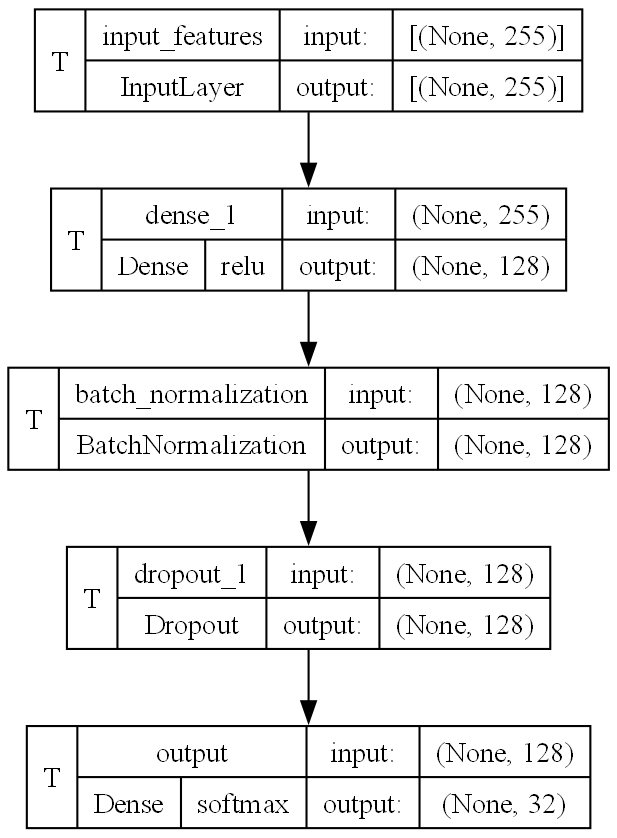

In [13]:
tf.keras.utils.plot_model(model, to_file="one_hid_layer_model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir="TB", expand_nested=False, dpi=150, show_layer_activations=True, show_trainable=True
                          )




In [8]:
es   = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
ckpt = ModelCheckpoint(
    "1hl_best_model.keras",
    save_best_only=True
)
tb = TensorBoard(log_dir="logs/one_hl")
start = time.time()
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=30,
    batch_size=64,
    callbacks=[scheduler, es, ckpt,tb]
)

total_time = time.time() - start
time_per_epoch = total_time / len(history.history['loss'])
print(f"Training time: {total_time:.1f}s ≃ {time_per_epoch:.2f}s/epoch")



Epoch 1/30


875/875 [==============================] - 2s 2ms/step - loss: 2.1334 - accuracy: 0.4520 - top_3_accuracy: 0.7506 - val_loss: 1.4865 - val_accuracy: 0.5453 - val_top_3_accuracy: 0.8767 - lr: 0.0010
Epoch 2/30
875/875 [==============================] - 1s 1ms/step - loss: 1.6611 - accuracy: 0.5438 - top_3_accuracy: 0.8675 - val_loss: 1.4609 - val_accuracy: 0.5530 - val_top_3_accuracy: 0.8747 - lr: 9.9000e-04
Epoch 3/30
875/875 [==============================] - 1s 1ms/step - loss: 1.6092 - accuracy: 0.5553 - top_3_accuracy: 0.8719 - val_loss: 1.4530 - val_accuracy: 0.5586 - val_top_3_accuracy: 0.8770 - lr: 9.8010e-04
Epoch 4/30
875/875 [==============================] - 1s 2ms/step - loss: 1.5816 - accuracy: 0.5613 - top_3_accuracy: 0.8753 - val_loss: 1.4479 - val_accuracy: 0.5610 - val_top_3_accuracy: 0.8808 - lr: 9.7030e-04
Epoch 5/30
875/875 [==============================] - 1s 1ms/step - loss: 1.5648 - accuracy: 0.5651 - top_3_accuracy: 0.8794 - val_loss: 1.4446 - val_

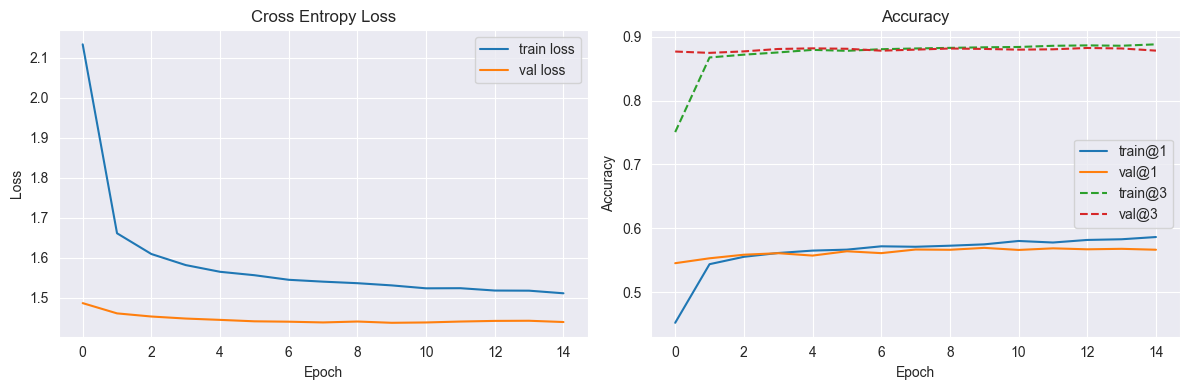

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))


plt.subplot(1,2,1)
plt.plot(history.history['loss'],     label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],           label='train@1')
plt.plot(history.history['val_accuracy'],       label='val@1')
plt.plot(history.history['top_3_accuracy'],     '--', label='train@3')
plt.plot(history.history['val_top_3_accuracy'], '--', label='val@3')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# 9. Final Validation Metrics
val_loss_final = history.history['val_loss'][-1]
val_acc_final  = history.history['val_accuracy'][-1]
val_top3_final = history.history['val_top_3_accuracy'][-1]
print("Val Loss:   ", val_loss_final)
print("Val Acc:    ", val_acc_final)
print("Val Top-3:  ", val_top3_final)


Val Loss:    1.4392495155334473
Val Acc:     0.5664166808128357
Val Top-3:   0.878166675567627


In [11]:
test_loss, test_acc, test_top3 = model.evaluate(
    X_test, y_test_oh,    
    batch_size=64, verbose=0
)
print("Test Loss:      ", test_loss)
print("Test Top-1 Acc: ", test_acc)
print("Test Top-3 Acc: ", test_top3)


Test Loss:       1.4266464710235596
Test Top-1 Acc:  0.5772500038146973
Test Top-3 Acc:  0.8847500085830688


In [12]:
# 11. Regression Metrics on Probabilities
probs    = model.predict(X_test, batch_size=64)
y_onehot = tf.one_hot(y_test, depth=32).numpy()

mse = np.mean((probs - y_onehot)**2)
mae = np.mean(np.abs(probs - y_onehot))

print("Test MSE: ", mse)
print("Test MAE: ", mae)


188/188 [==============================] - 0s 970us/step
Test MSE:  0.014904704
Test MAE:  0.03254894


In [13]:
# 12. Train vs. Val Gap
train_acc_final  = history.history['accuracy'][-1]
train_top3_final = history.history['top_3_accuracy'][-1]

gap_acc  = train_acc_final  - val_acc_final
gap_top3 = train_top3_final - val_top3_final
print("Gap Top-1 Acc:", gap_acc)
print("Gap Top-3 Acc:", gap_top3)


Gap Top-1 Acc: 0.019886910915374756
Gap Top-3 Acc: 0.009869039058685303


In [20]:
# 13. Save the Model
model.save("1hidL/one_layer_model.keras")


In [14]:
# 14. Summarize for Table
metrics_1hl = {
  'test_loss':       test_loss,
  'test_acc':        test_acc,
  'test_top3':       test_top3,
  'val_loss':        val_loss_final,
  'val_acc':         val_acc_final,
  'val_top3':        val_top3_final,
  'mse':             mse,
  'mae':             mae,
  'gap_acc':         gap_acc,
  'time_per_epoch':  time_per_epoch
}
metrics_1hl


{'test_loss': 1.4266464710235596,
 'test_acc': 0.5772500038146973,
 'test_top3': 0.8847500085830688,
 'val_loss': 1.4392495155334473,
 'val_acc': 0.5664166808128357,
 'val_top3': 0.878166675567627,
 'mse': 0.014904704,
 'mae': 0.03254894,
 'gap_acc': 0.019886910915374756,
 'time_per_epoch': 1.5777871131896972}

In [15]:

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val   shape:", X_val.shape)
print("y_val   shape:", y_val.shape)
print("X_test  shape:", X_test.shape)
print("y_test  shape:", y_test.shape)


X_train shape: (56000, 255)
y_train shape: (56000,)
X_val   shape: (12000, 255)
y_val   shape: (12000,)
X_test  shape: (12000, 255)
y_test  shape: (12000,)


In [16]:
preds = model.predict(X_test, batch_size=64).argmax(axis=1)

print("\nFirst 5 X_test rows:\n", X_test[:5])
print("First 5 model predictions:", preds[:5])
print("First 5 ground-truth labels:", y_test[:5])


188/188 [==============================] - 0s 1ms/step

First 5 X_test rows:
 [[0.         1.         0.         ... 0.         0.         0.11666667]
 [0.         0.         0.         ... 0.18333334 0.30833334 0.        ]
 [0.         1.         1.         ... 0.04166667 0.         0.        ]
 [0.         0.         0.         ... 0.         0.19166666 0.36666667]
 [0.         0.         0.         ... 0.11666667 0.31666666 0.20833333]]
First 5 model predictions: [ 1  8 25  4 15]
First 5 ground-truth labels: [30  8 25  4 12]


In [17]:
#16
sample_index = 0
base = X_test[sample_index:sample_index+1].copy()

# Flip a random feature
feature_to_flip = np.random.randint(0, base.shape[1])
modified = base.copy()
modified[0, feature_to_flip] = 1.0 - modified[0, feature_to_flip]

# Get probabilities
base_probs = model.predict(base, verbose=0)[0]
mod_probs  = model.predict(modified, verbose=0)[0]

# Display
print(f"Flipped feature index: {feature_to_flip}")
print("Base sample top-3 scores:", np.sort(base_probs)[-3:])
print("Modified top-3 scores:", np.sort(mod_probs)[-3:])
print("Base top-3 indices:", base_probs.argsort()[-3:][::-1])
print("Modified top-3 indices:", mod_probs.argsort()[-3:][::-1])

Flipped feature index: 102
Base sample top-3 scores: [0.11652116 0.1793566  0.22329813]
Modified top-3 scores: [0.11652116 0.1793566  0.22329813]
Base top-3 indices: [1 7 4]
Modified top-3 indices: [1 7 4]


375/375 [==============================] - 0s 845us/step


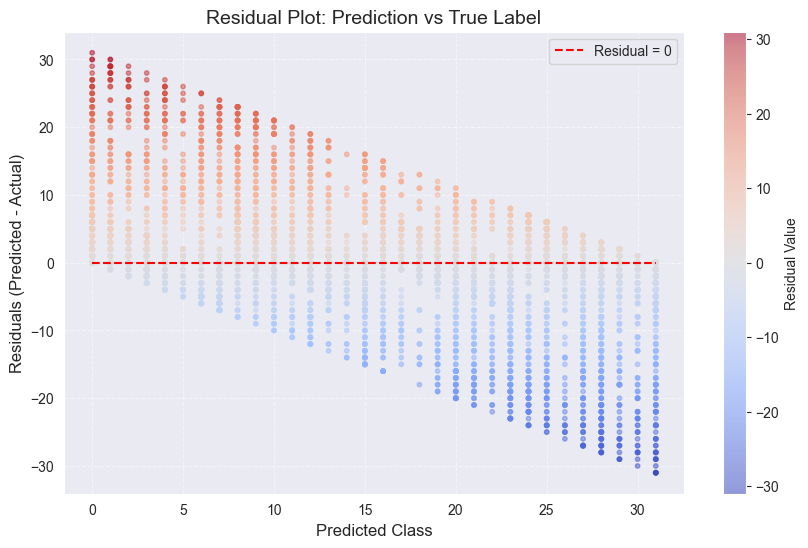

In [18]:
#17
import matplotlib.pyplot as plt

predictions = model.predict(X_test).argmax(axis=1)
test_y_flat = y_test.flatten()
residuals = test_y_flat - predictions

plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5, c=residuals, cmap='coolwarm', s=10)

plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), colors='r', linestyles='--', label='Residual = 0')

plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Residuals (Predicted - Actual)', fontsize=12)
plt.title('Residual Plot: Prediction vs True Label', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.colorbar(label='Residual Value')
plt.legend()
plt.show()


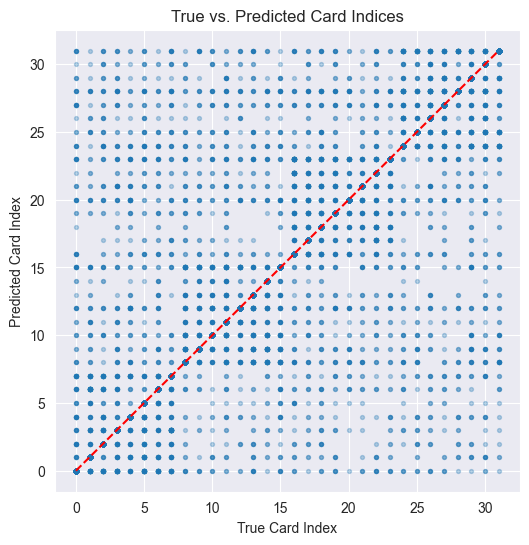

Pearson r between true and predicted labels: 0.744


In [19]:
#18
from scipy.stats import pearsonr
pred_labels = np.argmax(probs, axis=-1)

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_labels, alpha=0.3, s=8)
plt.plot([0,31], [0,31], 'r--')
plt.xlabel("True Card Index")
plt.ylabel("Predicted Card Index")
plt.title("True vs. Predicted Card Indices")
plt.show()

corr, _ = pearsonr(y_test, pred_labels)
print(f"Pearson r between true and predicted labels: {corr:.3f}")


375/375 [==============================] - 1s 1ms/step


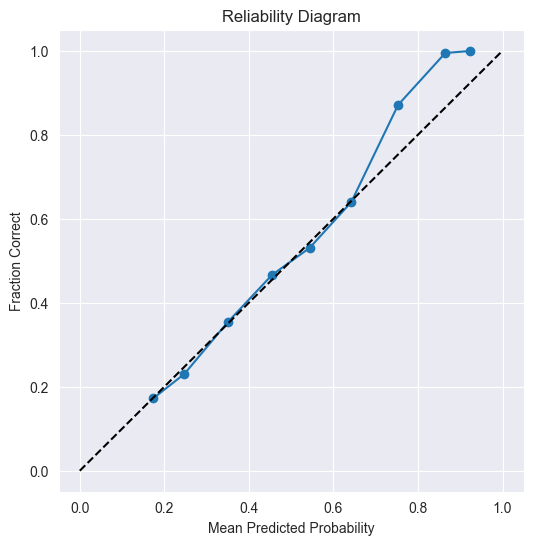

In [20]:
#22
from sklearn.calibration import calibration_curve
probs       = model.predict(X_val)
max_p       = probs.max(axis=1)
is_correct  = (probs.argmax(axis=1) == y_val)

frac_pos, mean_pred = calibration_curve(
    is_correct, max_p, n_bins=10, strategy='uniform'
)

plt.figure(figsize=(6,6))
plt.plot(mean_pred, frac_pos, marker='o')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction Correct")
plt.title("Reliability Diagram")
plt.show()


375/375 [==============================] - 0s 799us/step


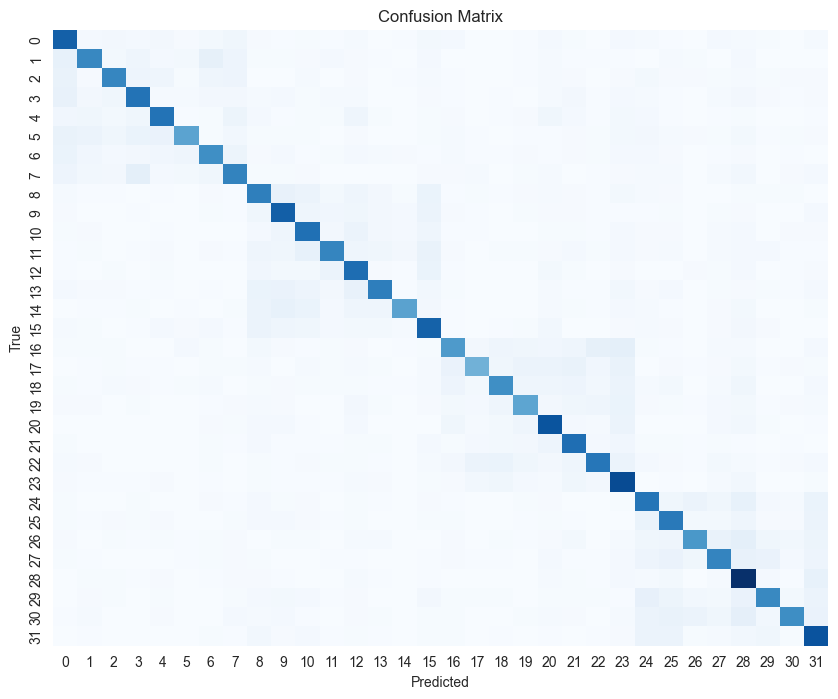

In [21]:
#23
preds = model.predict(X_test).argmax(axis=1)
cm    = confusion_matrix(y_test, preds, labels=range(32))

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()